# Style Transfer project

In this notebook, I used a photograph of myself and my daughter as the content image and watercolour paintings of Nicole De Brabandere (http://www.nicoledebrabandere.com/watercolors.html) as style images. I used all of her five watercolour paintings for the project. These images can be downloaded from her website. The paintings have both large and small scale features, which form her unique style. Therefore, I gave higher weight to style features derived from deeper convolution layers also.

The notebook is a modified version of the exercise notebook from the "Udacity - Intro to deep learning with Pytorch" course. The style transfer is based on Gatys et al (2016) article Image Style Transfer Using Convolutional Neural Networks, which uses VGGnet.

Since I used five paintings for the style, I defined a dictionary which contains weights for each painting, which is used in calculating the gram matrix for the final style.


In [1]:
import numpy as np
np.version.version

'1.14.5'

In [2]:
import torch
print(torch.__version__)

1.0.1.post2


In [3]:
# import external resources and libraries
# This project used numpy 1.14.5, check the version you are using via numpy( or np).version.version
# This project used torch 1.0.1.post2, check the version you are using via torch.__version__
%matplotlib inline

from PIL import Image # Image from Pillow is used to read the content and style images among other functions
from io import BytesIO # Useful for reading various types of image files
import matplotlib.pyplot as plt
#import numpy as np

#import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [4]:
# Check if GPU is available for training
print(torch.cuda.is_available())

False


In [5]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [6]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Load in Content and Style Images

You can load in any images you want! The `load_image` function loads in any type and size of image and also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [7]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, we load in images by file name and force the style image to be the same size as the content image.

In [8]:
# load in content and style image
content = load_image('images/IMG_0728.JPG').to(device)
# Resize style to match content, makes code easier
style1 = load_image('images/web_P_01.jpg', shape=content.shape[-2:]).to(device)
style2 = load_image('images/web_P_02.jpg', shape=content.shape[-2:]).to(device)
style3 = load_image('images/web_P_03.jpg', shape=content.shape[-2:]).to(device)
style4 = load_image('images/web_P_04.jpg', shape=content.shape[-2:]).to(device)
style5 = load_image('images/web_P_05.jpg', shape=content.shape[-2:]).to(device)

In [9]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

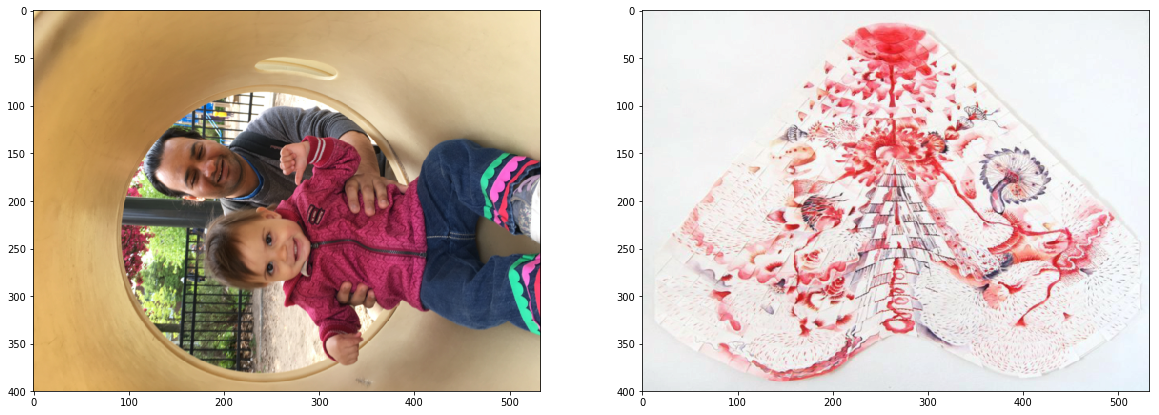

In [10]:
# To display the content and style images side-by-side use the code below
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style1))

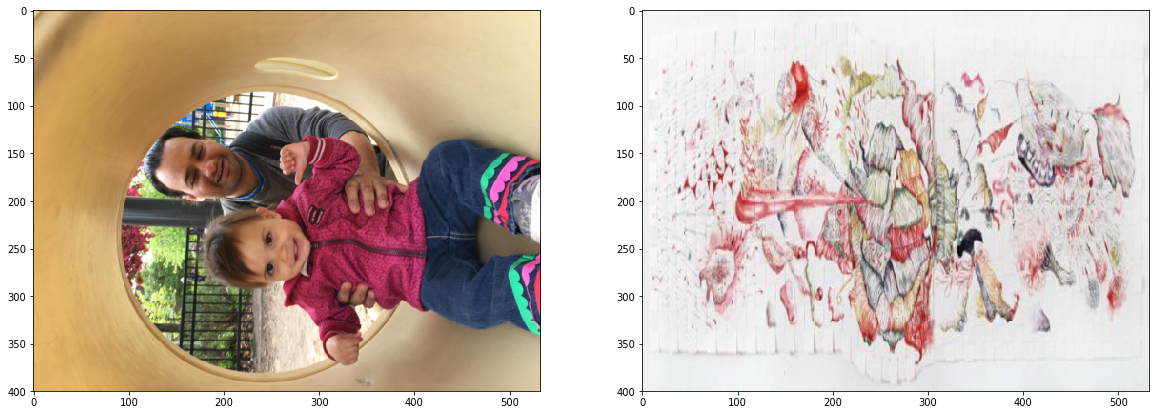

In [11]:
# To display the content and style images side-by-side use the code below
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style2))

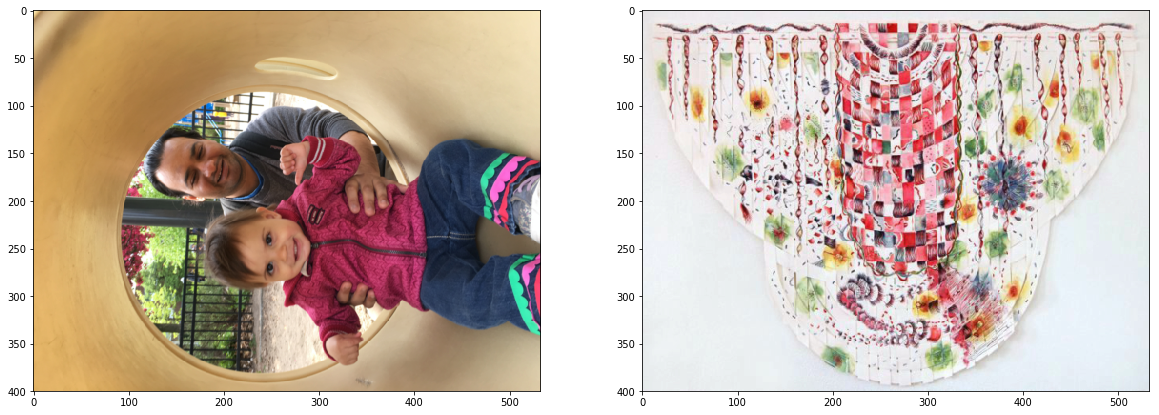

In [12]:
# To display the content and style images side-by-side use the code below
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style3))

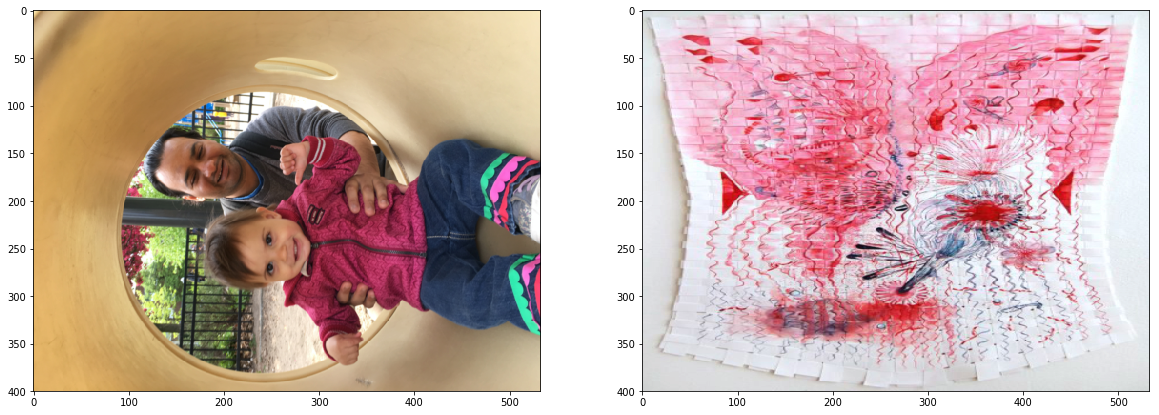

In [13]:
# To display the content and style images side-by-side use the code below
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style4))

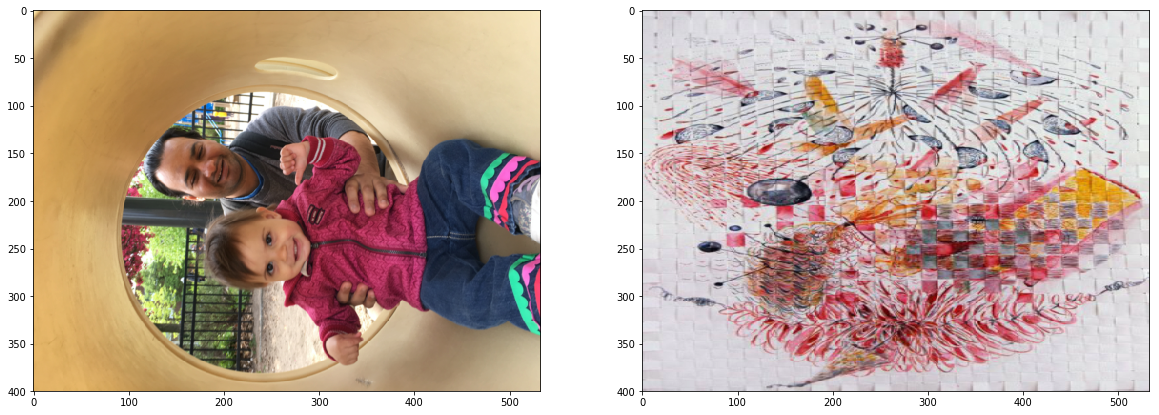

In [14]:
# To display the content and style images side-by-side use the code below
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style5))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [15]:
# print out VGG19 structure if you want to see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [16]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
                
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size()`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 


In [17]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    ## get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    ## reshape it, so we're multiplying the features for each channel
    tensor = tensor.view(d, h*w)
    ## calculate the gram matrix
    gram = torch.mm(tensor,tensor.t())
    
    return gram 

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [18]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features1 = get_features(style1, vgg)
style_features2 = get_features(style2, vgg)
style_features3 = get_features(style3, vgg)
style_features4 = get_features(style4, vgg)
style_features5 = get_features(style5, vgg)

# calculate the gram matrices for each layer of our style representation
# Note that there are five style images, so we have five sets of gram matrices
style_grams1 = {layer: gram_matrix(style_features1[layer]) for layer in style_features1}
style_grams2 = {layer: gram_matrix(style_features2[layer]) for layer in style_features2}
style_grams3 = {layer: gram_matrix(style_features3[layer]) for layer in style_features3}
style_grams4 = {layer: gram_matrix(style_features4[layer]) for layer in style_features4}
style_grams5 = {layer: gram_matrix(style_features5[layer]) for layer in style_features5}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

Below, you are given the option to weight the style representation at each relevant layer. It's suggested that you use a range between 0-1 to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, you can expect to get _larger_ style artifacts in your resulting, target image. Should you choose to weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

#### Content and Style Weight

Just like in the paper, we define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [19]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 1.0,
                 'conv3_1': 1.0,
                 'conv4_1': 1.0,
                 'conv5_1': 1.0}

# weights for each style paintings 


painting_weights = {'touchy_feely':0.1,
                    'cabbage_garden':0.1,
                    'hair_collar':0.1,
                    'in_the_frill':0.1,
                    'between_my_teeth':0.6}

content_weight = 1  # alpha
style_weight = 1e10  # beta

Total loss:  111446507520.0


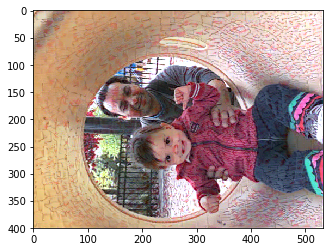

Total loss:  41631117312.0


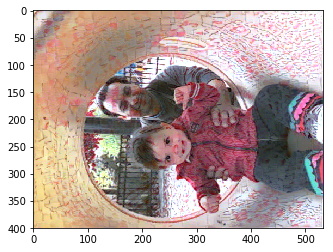

Total loss:  18361274368.0


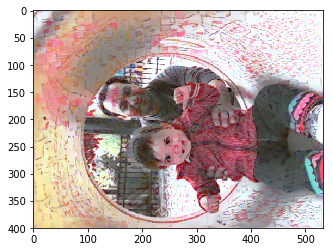

Total loss:  10008200192.0


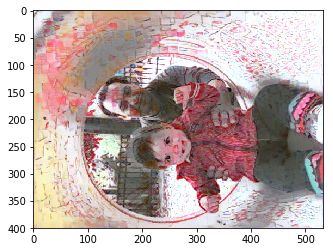

Total loss:  6126636032.0


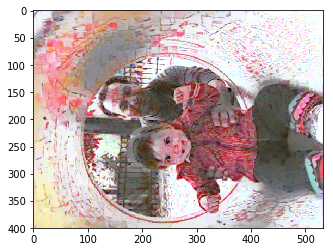

Total loss:  3987364864.0


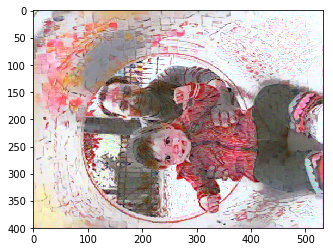

In [20]:
# for displaying the target image, intermittently
show_every = 1000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 6000

for ii in range(1, steps+1):
    
    ## get the features from your target image    
    ## then calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        ## Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        ## get the "style" style representation
        style_gram = painting_weights['touchy_feely']*style_grams1[layer]+\
                     painting_weights['cabbage_garden']*style_grams2[layer]+\
                     painting_weights['hair_collar']*style_grams3[layer]+\
                     painting_weights['in_the_frill']*style_grams4[layer]+\
                     painting_weights['between_my_teeth']*style_grams5[layer]
        ## Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    ## calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

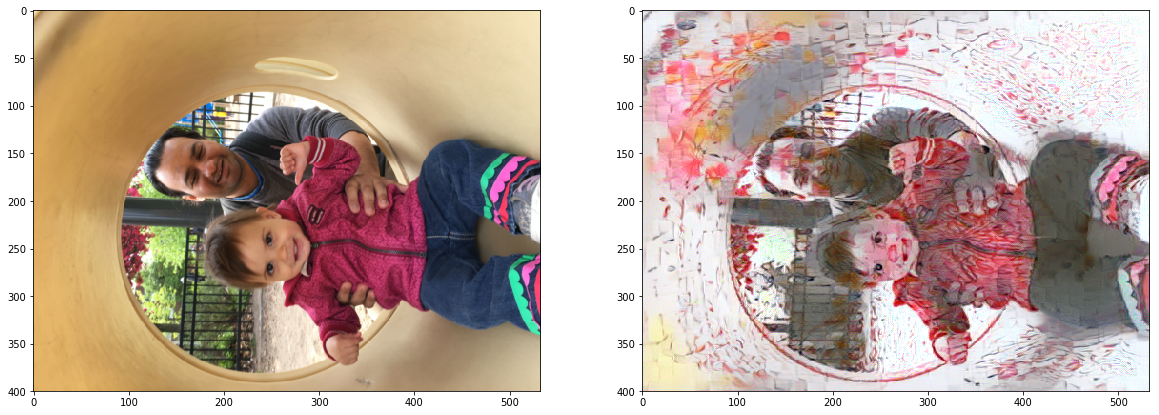

In [21]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))